In [381]:
#Import packages
#---------------------------------------
import sys
from matplotlib import pyplot as plt
import numpy as np
import json
import pandas as pd
import scanpy
import mne
import bioinfokit

#Import your modules
#---------------------------------------

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'

%load_ext autoreload
sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.9.16 (main, Jan 11 2023, 16:05:54) \n[GCC 11.2.0]'

# Load data

In [3]:
# Load plaque data
data_path = s_data + 'spatial_transcriptomics/plaques/030-D_S29.json'
with open(data_path, 'r') as j:
     plaq_df = json.loads(j.read())

In [4]:
# Load spot coordinates
coord_path = '/cndd2/agelber/hal/qc_aligned/030-D/outs/spatial/tissue_positions.csv'
coord_df = pd.read_csv(coord_path)

#Load PRECAST cluster labels
clust_path = '/cndd2/agelber/share/precast_030-D.csv'
clust_df = pd.read_csv(clust_path)

In [5]:
# filter out spots not in tissue
rows, cols = np.asarray([(plaq_df['oligo'][i]['row'],plaq_df['oligo'][i]['col']) for i in range(len(plaq_df['oligo']))]).T
rows, cols = rows[coord_df['in_tissue']==1], cols[coord_df['in_tissue']==1]
plq_bool = np.asarray([len(plaq_df['oligo'][i]) for i in range(len(plaq_df['oligo']))]) [coord_df['in_tissue']==1] > 7

In [ ]:
#Load spot genes
genes_path = '/cndd2/agelber/hal/qc_aligned/030-D/outs/filtered_feature_bc_matrix.h5'
gene_ = scanpy.read_10x_h5(genes_path)
gene_.var_names_make_unique()

#preprocess genes
scanpy.pp.filter_cells(gene_, min_genes=0)
scanpy.pp.filter_genes(gene_, min_cells=10)
scanpy.pp.normalize_total(gene_, target_sum=1e6)
gene_m = gene_.X.toarray()

#Load spot genes
genes_path = '/cndd2/agelber/hal/qc_aligned/030-D/outs/filtered_feature_bc_matrix.h5'
gene_p = scanpy.read_10x_h5(genes_path)
gene_p.var_names_make_unique()
gene_pm = gene_p.X.toarray()

# Visualise plaques



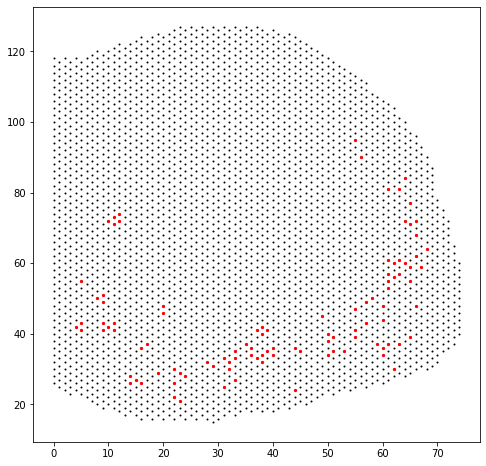

In [6]:
#PLOT PLAQUES

fig = plt.figure(figsize=(8,8))
plt.scatter(rows, cols, s=1, c='k')
plt.scatter(rows[plq_bool], cols[plq_bool], s=5, c='red')
plt.show()

In [30]:
#PLOT CLUSTERS
clust_l, row_ind = list(range(len(np.unique(clust_df['cluster'])))),list(range(len(np.unique(clust_df['cluster']))))
for x in range(len(np.unique(clust_df['cluster']))):
    clust_l[x] = clust_df['cell'][clust_df['cluster'] == x+1]
    row_ind[x] = [np.where(np.array(clust_l[x].iloc[i] == coord_df['barcode'][coord_df['in_tissue']==1] ) ==True)[0][0] for i in range(len(clust_l[x]))]

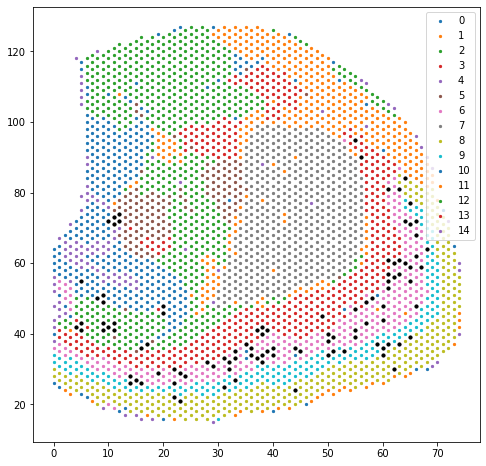

In [45]:
fig = plt.figure(figsize=(8,8))
for x in range(len(np.unique(clust_df['cluster']))): plt.scatter(rows[row_ind[x]], cols[row_ind[x]], s=5, label = str(x))
plt.scatter(rows[plq_bool], cols[plq_bool], s=10, c='k')
plt.legend()
#plt.savefig('fig_dump/plaque-clusters-01.svg', transparent=True)
plt.show()


In [36]:
range(len(np.unique(clust_df['cluster'])))

range(0, 15)

In [43]:
len(row_ind)

15

In [64]:
plq_bool.shape ,np.intersect1d(np.where(plq_bool == True)[0], row_ind[x])

((3552,), array([], dtype=int64))

In [63]:
np.where(plq_bool == True)[0]

array([ 208,  209,  210,  222,  407,  409,  415,  416,  417,  509,  510,
        511,  539,  540,  541,  645,  647,  705,  706,  707,  813,  823,
        824,  925, 1052, 1054, 1137, 1138, 1142, 1145, 1146, 1256, 1484,
       1485, 1590, 1598, 1703, 1706, 1708, 1709, 1711, 1823, 1929, 1930,
       1932, 1937, 2038, 2040, 2041, 2046, 2047, 2048, 2149, 2151, 2353,
       2364, 2365, 2580, 2667, 2668, 2671, 2672, 2673, 2763, 2860, 2862,
       2868, 2916, 2954, 2960, 3001, 3035, 3048, 3115, 3117, 3118, 3125,
       3129, 3134, 3136, 3138, 3142, 3162, 3190, 3197, 3216, 3217, 3220,
       3221, 3241, 3275, 3291, 3295, 3296, 3307, 3308, 3313, 3320, 3354,
       3365, 3368, 3374, 3378, 3436])

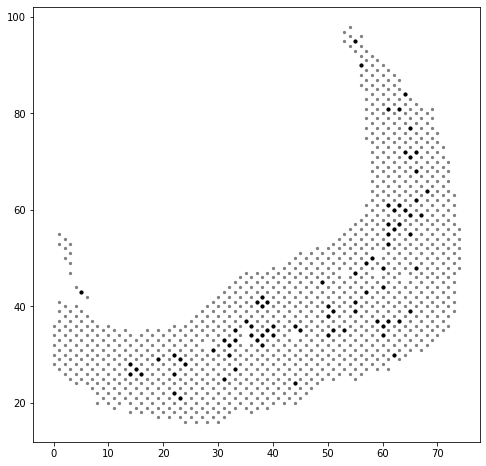

In [68]:
#Cortex plaques
cort_l = [3,6,8,9]

fig = plt.figure(figsize=(8,8))
for x in range(len(np.unique(clust_df['cluster']))): 
    if x in cort_l:
        plt.scatter(rows[row_ind[x]], cols[row_ind[x]], s=5, label = str(x), c = 'grey')
        plt.scatter(rows[np.intersect1d(np.where(plq_bool == True)[0], row_ind[x])], cols[np.intersect1d(np.where(plq_bool == True)[0], row_ind[x])], s=10, c='k')
plt.savefig('fig_dump/plaque-clusters-cortex-01.svg', transparent=True)
plt.show()


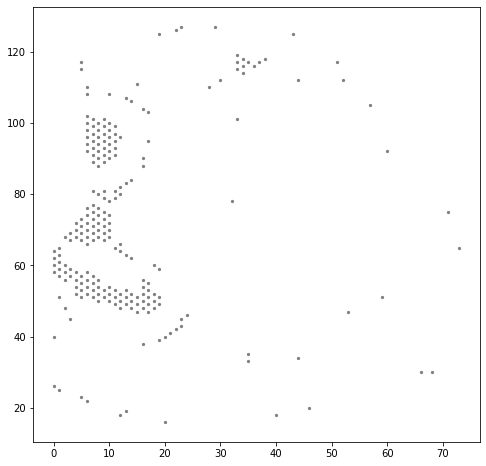

In [54]:
# Specific clusters

#Cortex plaques
cort_l = [0]

fig = plt.figure(figsize=(8,8))
for x in range(len(np.unique(clust_df['cluster']))): 
    if x in cort_l:
        plt.scatter(rows[row_ind[x]], cols[row_ind[x]], s=5, label = str(x), c = 'grey')
        #plt.scatter(rows[plq_bool], cols[plq_bool], s=10, c='k')
#plt.savefig('fig_dump/plaque-clusters-01.svg', transparent=True)
plt.show()


# Do differential expression
* plaques vs no plaque within a slice across all genes
* apply within cluster
* Split up and treat each spot as a sample
* Wilcoxon on cpm
* FDR corrected / Bonferroni

## Whole slice


In [15]:
gene_m.shape, rows.shape

((3552, 16805), (3552,))

In [542]:
# Find DE genes

umi_plq = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool]
umi_norm = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool==False]

geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, umi_plq.shape, genenorm_m.shape, umi_norm.shape

import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = gene_.var.index[sig_v]


In [543]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])
lgf2[np.isnan(lgf2)] = 0
value1 = np.asarray([np.mean(genenorm_m[:,i]) for i in range(gene_m.shape[1])])
value2 = np.asarray([np.mean(geneplq_m[:,i]) for i in range(gene_m.shape[1])])
df = {'GeneNames': np.array(gene_.var.index), 'value1': value1, 'value2':value2, 'log2FC': lgf2, 'p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]

df


<ipython-input-543-7670b90127a2>:2: RuntimeWarning: invalid value encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])


,GeneNames,value1,value2,log2FC,p-value
0,Xkr4,1.594261,1.034647,0.000000,9.445994e-01
1,Gm19938,0.971128,2.124656,0.206052,2.717138e-02
2,Sox17,5.309881,7.096316,0.837084,5.003480e-02
3,Mrpl15,41.813095,53.725334,3.574373,1.055117e-02
4,Lypla1,29.717205,40.485680,3.428742,2.820086e-03
...,...,...,...,...,...
16800,Spry3,9.515156,15.462439,2.572231,2.113764e-03
16801,Tmlhe,2.927776,5.302159,1.247553,9.931781e-04
16802,CAAA01147332.1,0.511697,0.863103,-1.508787,3.150635e-01
16803,AC149090.1,210.750290,203.011078,0.000000,2.866477e-01


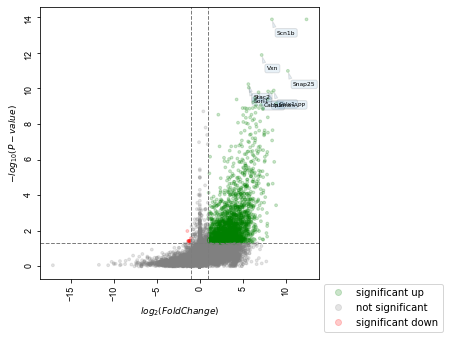

In [544]:
from bioinfokit import analys, visuz
# load dataset as pandas dataframe

visuz.GeneExpression.volcano(df=df, lfc='log2FC', pv='p-value', geneid = 'GeneNames', valpha = 0.2, genenames = tuple(top_n),gstyle=2, sign_line=True
                             ,plotlegend=True, legendpos='upper right',legendanchor=(1.46,0), show=True)
                            

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


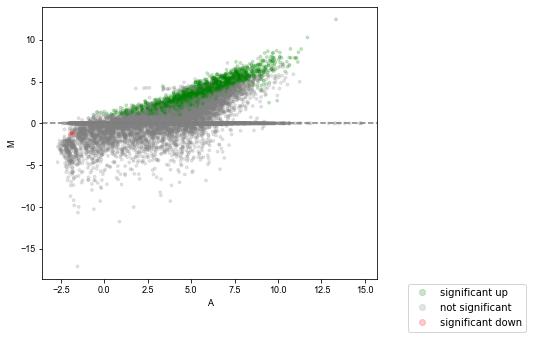

In [521]:
visuz.GeneExpression.ma(df=df, lfc='log2FC', ct_count='value1', st_count = 'value2',pv='p-value', valpha = 0.2, plotlegend=True, legendpos='upper right',legendanchor=(1.46,0),show=True)


In [373]:
# Visualise different DE gene expression in space
curr = 'Cd63'
if curr not in sig_genes:
    print('not a DE gene')
else:
    gene_ind = np.where(gene_.var.index== curr)[0][0]

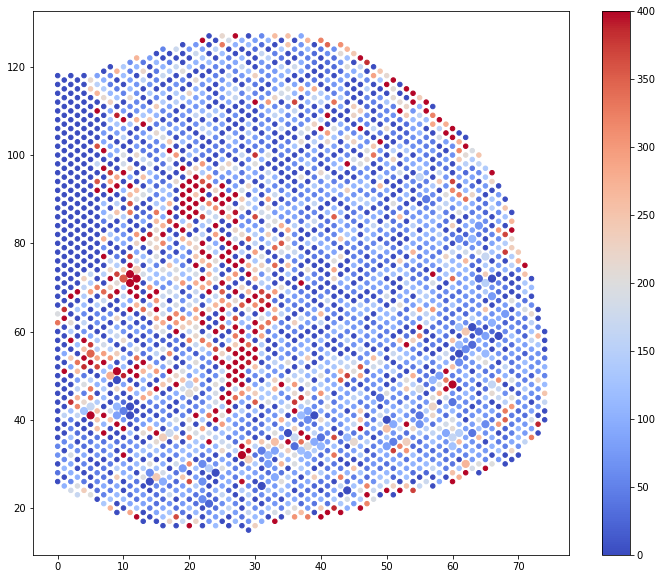

In [374]:

fig = plt.figure(figsize=(12,10))
plt.scatter(rows[plq_bool ==False], cols[plq_bool == False], s=20,c=genenorm_m[:,gene_ind], cmap='coolwarm', vmin = 0, vmax = 400)
plt.scatter(rows[plq_bool ==True], cols[plq_bool == True], s=50, c=geneplq_m[:,gene_ind], cmap='coolwarm', vmin = 0, vmax = 400)
plt.colorbar()
#plt.legend()
plt.savefig('fig_dump/plaque-cd63.png', transparent=True)
plt.show()

## Clusters


In [238]:
# Group by cluster region
def match(curr_umi, umi_plq, umi_norm):
    curr_plq = np.intersect1d(umi_plq,curr_umi)
    curr_norm = np.intersect1d(umi_norm,curr_umi)
    return(curr_norm, curr_plq)

umi_plq = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool]
umi_norm = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool==False]
umi_split_l = [match(clust_l[i], umi_plq, umi_norm) for i in range(len(clust_l))]

In [132]:
#Select cluster 
#Only do DE on clusters with > 5 spots with plaques
for i in range(len(umi_split_l)):
    print('clust ' + str(i) + ' n-plaques=' + str(len(umi_split_l[i][1])))
        


clust 0 n-plaques=4
clust 1 n-plaques=0
clust 2 n-plaques=4
clust 3 n-plaques=16
clust 4 n-plaques=1
clust 5 n-plaques=3
clust 6 n-plaques=46
clust 7 n-plaques=0
clust 8 n-plaques=8
clust 9 n-plaques=13
clust 10 n-plaques=1
clust 11 n-plaques=1
clust 12 n-plaques=6
clust 13 n-plaques=1
clust 14 n-plaques=0


In [350]:
# choose cluster
ch = 6
umi_norm = umi_split_l[ch][0]
umi_plq = umi_split_l[ch][1]
geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, genenorm_m.shape

((46, 16805), (246, 16805))

In [351]:
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = gene_.var.index[sig_v]


In [352]:
np.sort(sig_genes)


array(['Gm19522'], dtype=object)

In [545]:
# Group by cortical regions (3,6,8,9)
cort_l = [3,6,8,9]
ch = 3
umi_norm = np.hstack(([umi_split_l[i][0] for i in cort_l]))
umi_plq = np.hstack(([umi_split_l[i][1] for i in cort_l]))
geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, genenorm_m.shape

((83, 16805), (1068, 16805))

In [546]:
import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = gene_.var.index[sig_v]


In [547]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])
lgf2[np.isnan(lgf2)] = 0
value1 = np.asarray([np.mean(genenorm_m[:,i]) for i in range(gene_m.shape[1])])
value2 = np.asarray([np.mean(geneplq_m[:,i]) for i in range(gene_m.shape[1])])
df = {'GeneNames': np.array(gene_.var.index), 'value1': value1, 'value2':value2, 'log2FC': lgf2, 'adjusted p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]

df


<ipython-input-547-e8d7026e9826>:2: RuntimeWarning: invalid value encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])
<ipython-input-547-e8d7026e9826>:2: RuntimeWarning: divide by zero encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])


,GeneNames,value1,value2,log2FC,adjusted p-value
0,Xkr4,1.546096,1.296426,0.000000,0.969011
1,Gm19938,1.306514,2.662219,0.439044,0.630130
2,Sox17,5.139546,5.154336,-6.079228,0.915314
3,Mrpl15,46.013012,60.985088,3.904202,0.125666
4,Lypla1,35.458939,45.381691,3.310740,0.435866
...,...,...,...,...,...
16800,Spry3,10.930652,14.435506,1.809354,0.633908
16801,Tmlhe,2.603630,6.070763,1.793743,0.169329
16802,CAAA01147332.1,0.781406,1.081479,-1.736617,0.915314
16803,AC149090.1,245.203796,226.067413,0.000000,0.795985


<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


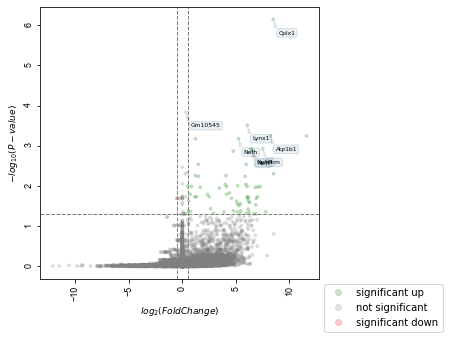

In [552]:
from bioinfokit import analys, visuz
# load dataset as pandas dataframe

visuz.GeneExpression.volcano(df=df, lfc='log2FC', pv='adjusted p-value', geneid = 'GeneNames', lfc_thr=(0.5,0.5), valpha = 0.2, genenames = tuple(top_n),gstyle=2, sign_line=True
                             ,plotlegend=True, legendpos='upper right',legendanchor=(1.46,0), show=True)
                            

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


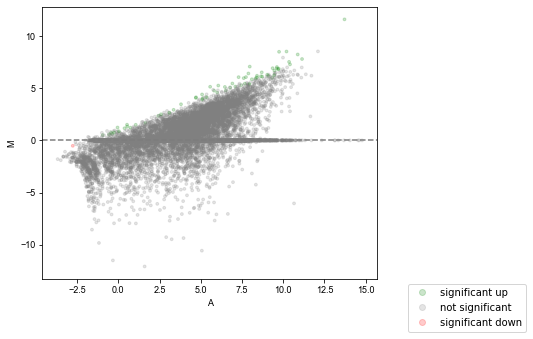

In [555]:
visuz.GeneExpression.ma(df=df, lfc='log2FC', ct_count='value1', st_count = 'value2',pv='adjusted p-value', lfc_thr=(0.5,0.5), valpha = 0.2, plotlegend=True, legendpos='upper right',legendanchor=(1.46,0),show=True)


In [270]:
np.sort(sig_genes)

array(['Abcd2', 'Accsl', 'Acot7', 'Ankrd66', 'Atp1a3', 'Atp1b1', 'Atp5b',
       'Atp5g3', 'Atp6ap2', 'Bcat1', 'Bcl6', 'Camk2a', 'Catip', 'Cd1d1',
       'Ckb', 'Col4a4', 'Colec11', 'Cox5a', 'Cplx1', 'Crip2', 'Ddn',
       'Dynll2', 'Epop', 'Epx', 'Ermard', 'Fanci', 'Fezf2', 'Gas2l3',
       'Gas5', 'Gbx1', 'Glrb', 'Gm10545', 'Gm17396', 'Gm20751', 'Gm2762',
       'Gm29737', 'Gm47814', 'Haghl', 'Hapln4', 'Hcn2', 'Hpcal4',
       'Ifi207', 'Ifitm6', 'Ina', 'Kcna2', 'Kctd9', 'Ldhb', 'Lipc',
       'Lynx1', 'Map1b', 'Marcks', 'Nat8l', 'Ndufc2', 'Nefh', 'Nefl',
       'Nefm', 'Nell1', 'Nrip3', 'Olfm1', 'Pcp4', 'Pde6c', 'Pde6g',
       'Peg13', 'Pkm', 'Pphln1', 'Psph', 'Pvalb', 'Pygm', 'Qrfpr',
       'Rasgef1a', 'Ripply3', 'Scn1b', 'Scn4b', 'Slpi', 'Smad3', 'Sorl1',
       'Stmn3', 'Sub1', 'Syt2', 'Tecr', 'Teddm3', 'Thy1', 'Tmem74bos',
       'Tshz2', 'Tubb3', 'Vamp1', 'Zdhhc15', 'Zfyve9', 'humanAPP'],
      dtype=object)

In [285]:
# Visualise different DE gene expression
curr = 'humanAPP'
if curr not in sig_genes:
    print('not a DE gene')
else:
    gene_ind = np.where(gene_.var.index== curr)[0][0]

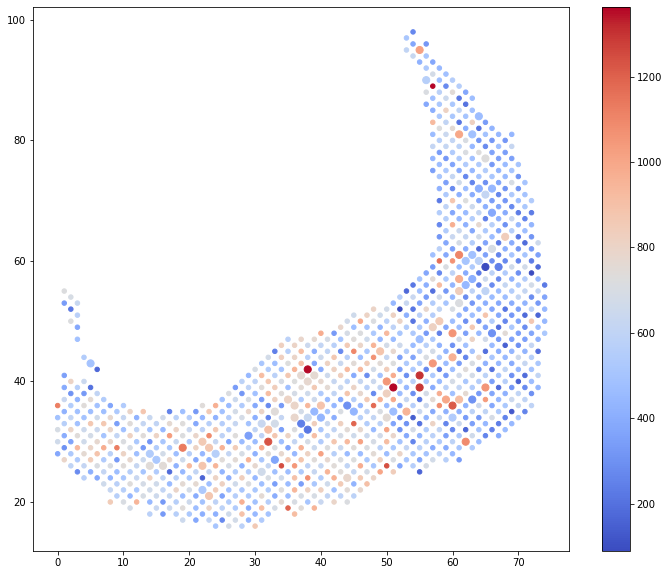

In [286]:
cort_l = [3,6,8,9]

fig = plt.figure(figsize=(12,10))
curr_plq_ind = np.intersect1d(np.hstack([row_ind[x] for x in cort_l]) , np.where(plq_bool == True)[0])
curr_norm_ind = np.intersect1d(np.hstack([row_ind[x] for x in cort_l]) , np.where(plq_bool == False)[0])

plt.scatter(rows[curr_norm_ind], cols[curr_norm_ind], s=20,c=genenorm_m[:,gene_ind], cmap='coolwarm')#, vmin = 0, vmax = 400)
plt.scatter(rows[curr_plq_ind], cols[curr_plq_ind], s=50, c=geneplq_m[:,gene_ind], cmap='coolwarm')#, vmin = 0, vmax = 400)
plt.colorbar()
#plt.legend()
plt.savefig('fig_dump/plaque-cortex-humanAPP.png', transparent=True)
plt.show()

In [131]:
sig_genes

Index(['Atp1b1', 'Zfyve9', 'Cplx1', 'Thy1', 'Pkm', 'Nefh', 'Pde6g', 'Nefm',
       'Nefl', 'Sub1', 'Lynx1', 'Pphln1', 'Gm10545', 'Ina'],
      dtype='object')